In [2]:
import pickle
import numpy as np

In [3]:
with open("train_qa.txt", "rb") as fp:   
    train_data =  pickle.load(fp)

In [4]:
with open("test_qa.txt", "rb") as fp:  
    test_data =  pickle.load(fp)

In [5]:
vocab = set()

In [6]:
all_data = test_data + train_data

In [7]:
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [8]:
vocab.add('no')
vocab.add('yes')

In [9]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [10]:
vocab_len = len(vocab) + 1 

In [11]:
max_story_len = max([len(data[0]) for data in all_data])

In [12]:
max_story_len

156

In [13]:
max_question_len = max([len(data[1]) for data in all_data])

In [14]:
vocab_size = len(vocab) + 1

In [15]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [16]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [17]:
tokenizer.word_index

{'yes': 1,
 '.': 2,
 '?': 3,
 'moved': 4,
 'bedroom': 5,
 'took': 6,
 'left': 7,
 'put': 8,
 'kitchen': 9,
 'journeyed': 10,
 'is': 11,
 'dropped': 12,
 'football': 13,
 'grabbed': 14,
 'up': 15,
 'no': 16,
 'hallway': 17,
 'sandra': 18,
 'apple': 19,
 'john': 20,
 'picked': 21,
 'there': 22,
 'got': 23,
 'back': 24,
 'garden': 25,
 'daniel': 26,
 'discarded': 27,
 'down': 28,
 'went': 29,
 'bathroom': 30,
 'office': 31,
 'in': 32,
 'travelled': 33,
 'milk': 34,
 'mary': 35,
 'the': 36,
 'to': 37}

In [18]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [19]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)


In [20]:
len(train_story_seq)

10000

In [21]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1
        
       
        X.append(x)
        Xq.append(xq)
        Y.append(y)
  
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [22]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [23]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [24]:
inputs_test

array([[ 0,  0,  0, ..., 36,  5,  2],
       [ 0,  0,  0, ..., 36, 25,  2],
       [ 0,  0,  0, ..., 36, 25,  2],
       ...,
       [ 0,  0,  0, ..., 36, 19,  2],
       [ 0,  0,  0, ..., 36, 25,  2],
       [ 0,  0,  0, ..., 19, 22,  2]])

In [25]:
queries_test

array([[11, 20, 32, 36,  9,  3],
       [11, 20, 32, 36,  9,  3],
       [11, 20, 32, 36, 25,  3],
       ...,
       [11, 35, 32, 36,  5,  3],
       [11, 18, 32, 36, 25,  3],
       [11, 35, 32, 36, 25,  3]])

In [26]:
sum(answers_test)

array([  0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [27]:
tokenizer.word_index['yes']

1

In [28]:
tokenizer.word_index['no']

16

In [29]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [30]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [31]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [32]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [33]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [34]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [35]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [36]:
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  

In [37]:
answer = concatenate([response, question_encoded])

In [38]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [39]:
answer = LSTM(32)(answer)

In [40]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [41]:
answer = Activation('softmax')(answer)

model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 64)             2432      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 6, 64)                2432      ['input_2[0][0]']             
                                                                                              

In [43]:
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=100,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 5s 9ms/step - loss: 0.9171 - accuracy: 0.4902 - val_loss: 0.6948 - val_accuracy: 0.5030
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.7063 - accuracy: 0.4972 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6979 - accuracy: 0.5001 - val_loss: 0.6939 - val_accuracy: 0.4970
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6968 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6956 - accuracy: 0.5001 - val_loss: 0.6959 - val_accuracy: 0.4970
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6947 - accuracy: 0.5106 - val_loss: 0.6949 - val_accuracy: 0.4970
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6962 - accuracy: 0.4914 - val_loss: 0.6935 - val_accuracy: 0.5030

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


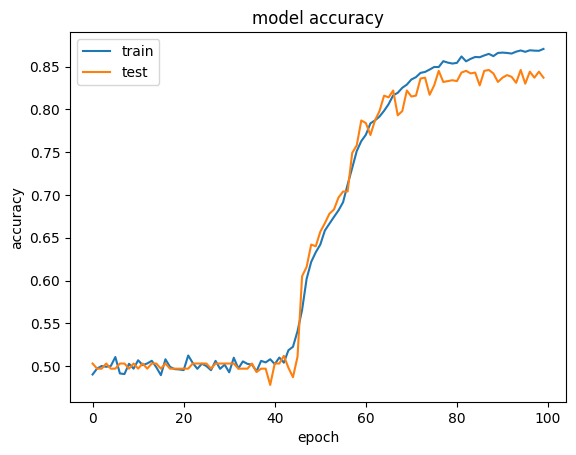

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
model.save('mymodel.h5')

c:\Users\Sangharsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
pred_results = model.predict(([inputs_test,queries_test]))

32/32 [==============================] - 1s 3ms/step


In [50]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [51]:
pred_results

array([[1.0849386e-06, 1.6861602e-03, 1.0343123e-06, ..., 1.2463154e-06,
        1.2054523e-06, 6.9493046e-07],
       [3.9256678e-09, 8.6482975e-04, 3.6856647e-09, ..., 4.9406266e-09,
        4.8693574e-09, 3.1549401e-09],
       [7.1583006e-09, 8.6515236e-01, 9.1263663e-09, ..., 8.4042684e-09,
        7.3584623e-09, 7.7914244e-09],
       ...,
       [6.0117543e-08, 9.6762972e-04, 5.2731419e-08, ..., 6.9570568e-08,
        6.4947663e-08, 4.5337831e-08],
       [6.5169765e-08, 9.2864931e-01, 8.9974669e-08, ..., 7.9106087e-08,
        6.0699271e-08, 7.3890554e-08],
       [7.8088327e-08, 9.5261526e-01, 1.0838698e-07, ..., 9.7180070e-08,
        7.6834425e-08, 8.8765248e-08]], dtype=float32)

In [52]:
val_max = np.argmax(pred_results[0])

In [53]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [54]:
k

'no'

In [55]:
pred_results[0][val_max]

0.9982741

In [56]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [57]:
story = "John left the kitchen . Sandra dropped the football in the garden ."

In [58]:
story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [59]:
my_que = "Is the football in the garden ?"

In [60]:
my_que.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [63]:
mydata = [(story.split(),my_que.split(),'yes')]

In [64]:
story,my_que,my_ans = vectorize_stories(mydata)

In [65]:
pred_results = model.predict(([story,my_que]))

1/1 [==============================] - 0s 20ms/step


In [66]:
val_max = np.argmax(pred_results[0])

In [67]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [68]:
k

'yes'